## Introduction
This notebook loads DWUG DE's additional sense annotation and creates cluster stats and change scores.

In [1]:
# import scripts from parent folder
import sys
sys.path.append('../')

import os
from pathlib import Path

output_path = 'dwug_de_sense'
Path(output_path).mkdir(parents=True, exist_ok=True)

### Load data

In [2]:
# reference data set for experiments: DWUG DE (V2.0.0)
import requests
dwug_de = 'https://zenodo.org/record/7386402/files/dwug_de.zip?download=1'
r = requests.get(dwug_de, allow_redirects=True)
f = 'dwug_de.zip'
open(f, 'wb').write(r.content)

import zipfile
with zipfile.ZipFile(f) as z:
    z.extractall()

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import shutil

# big dataset
dataset_path = 'dwug_de'

# Extract grouping (time) information
df_dwug_de_uses = pd.DataFrame()
for p in Path(dataset_path+'/data').glob('*/uses.csv'):
    df_dwug_de_uses = pd.concat([df_dwug_de_uses, pd.read_csv(p, delimiter='\t', quoting=3, na_filter=False)])
display(df_dwug_de_uses)

# Copy judgments and senses
for p in Path(dataset_path+'/data').glob('*/judgments_senses.csv'):
    data_output = output_path + '/data/{0}'.format(str(p).split('/')[-2])
    Path(data_output).mkdir(parents=True, exist_ok=True)
    shutil.copyfile(p, data_output+'/judgments_senses.csv')
    
for p in Path(dataset_path+'/data').glob('*/senses.csv'):
    data_output = output_path + '/data/{0}'.format(str(p).split('/')[-2])
    Path(data_output).mkdir(parents=True, exist_ok=True)
    shutil.copyfile(p, data_output+'/senses.csv')    

,lemma,pos,date,grouping,identifier,description,context,indexes_target_token,indexes_target_sentence,context_tokenized,indexes_target_token_tokenized,indexes_target_sentence_tokenized,context_lemmatized,context_pos,context_normalized
0,voranstellen,VVIZU,1891,1,lehnert_seehaefen01_1891-30-14,,"Von der ursprünglichen Absicht, demselben als ...",107:121,0:207,"Von der ursprünglichen Absicht , demselben als...",14,0:31,"von d ursprünglich Absicht , demselben als Ein...","APPR ART ADJA NN $, ADJA KOKOM NN ART NN ART N...","Von der ursprünglichen Absicht , demselben als..."
1,voranstellen,VVFIN,1870,1,schmoller_kleingewerbe_1870-6005-25,,Sie ist dann berechtigt und steht mit der ganz...,157:168,0:182,Sie iſt dann berechtigt und ſteht mit der ganz...,25,0:29,sie sein dann berechtigt und stehen mit d ganz...,PPER VAFIN ADV ADJD KON VVFIN APPR ART ADJA NN...,Sie ist dann berechtigt und steht mit der ganz...
2,voranstellen,VVPP,1895,1,schroeder_logik03_1895-1006-4,,Als ganz fundamental sei vorangestellt der Sat...,25:38,0:326,Als ganz fundamental sei vorangestellt der Sat...,4,0:75,als ganz fundamental sein voranstellen d Satz ...,KOKOM ADV ADJD VAFIN VVPP ART NN $. CARD $( $(...,Als ganz fundamental sei vorangestellt der Sat...
3,voranstellen,VVINF,1834,1,wienbarg_plattdeutsch_1834-104-8,,Muß ich nicht Luther selbst und die Reformatio...,48:60,0:61,Muß ich nicht Luther selbst und die Reformatio...,8,0:10,müssen ich nicht Luther selbst und d Reformati...,VMFIN PPER PTKNEG NE ADV KON ART NN VVINF $.,Muß ich nicht Luther selbst und die Reformatio...
4,voranstellen,VVPP,1846,1,vischer_aesthetik01_1846-511-62,,Es kann z. B. eine Philosophie ein verhältnißm...,386:399,0:497,Es kann z. B. eine Philoſophie ein verhältnißm...,62,0:77,es können z. B. eine Philosophie eine verhältn...,PPER VMFIN APPRART NN ART NN ART ADV ADV ADJA ...,Es kann z. B. eine Philosophie ein verhältnism...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Titel,NN,1955,2,26120215_1955_02_04_01_013.tcf.xml-8-6,,Erstmalig wurde auch aktiven Sportlern der Tit...,43:48,0:138,Erstmalig wurde auch aktiven Sportlern der Tit...,6,0:24,erstmalig werden auch aktiv Sportler d Titel v...,ADJD VAFIN ADV ADJA NN ART NN ADJA NN ART NN V...,
196,Titel,NN,1964,2,26120215_1964_04_22_01_110.tcf.xml-15-9,,Die besten Judoka aus 18 Ländern streben nach ...,50:55,0:81,Die besten Judoka aus 18 Ländern streben nach ...,9,0:17,d gut Judoka aus 18 Land streben nach d Titel ...,"ART ADJA NN APPR CARD NN VVFIN APPR ART NN $, ...",
197,Titel,NN,1955,2,26120215_1955_05_21_02_133.tcf.xml-13-5,,Mehrfach holte er sich den Titel eines Speedwa...,27:32,0:66,Mehrfach holte er sich den Titel eines Speedwa...,5,0:11,Mehrfach holen er sich d Titel eine Speedway-C...,NN VVFIN PPER PRF ART NN ART NN ART NE $.,
198,Titel,NN,1973,2,2532889X_1973-09-18_01_077.tcf.xml-5-14,,war Meister Alexander Tschutkich aus dem Krasn...,110:115,0:156,war Meister Alexander Tschutkich aus dem Krasn...,14,0:22,sein Meister Alexander Tschutkich aus d krasno...,VAFIN NE NE NE APPR ART ADJA NN ART NN ART NN ...,


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from cluster_ import *

# Load word sense annotation for DWUG DE
df_dwug_de_senses = pd.DataFrame()
for p in Path(dataset_path+'/data').glob('*/judgments_senses.csv'):
    judgments = pd.read_csv(p, delimiter='\t')
    senses = pd.read_csv(str(p).replace('judgments_',''), delimiter='\t')
    judgments = pd.merge(judgments, senses, left_on='identifier_sense', right_on="identifier_sense", how ='outer')
    #judgments = judgments[~(judgments['description_sense'] == 'andere')] # remove andere instances
    #judgments['identifier_sense'] = judgments['lemma'] + judgments['identifier_sense'] # prefix senses for uniqueness across lemmas
    judgments.loc[judgments['description_sense'] == 'andere', 'identifier_sense'] = 'andere' # keep, but label them
    lemmas = judgments.groupby('identifier').agg({'lemma':lambda x: list(x)[0]})
    judgmentsA = judgments[judgments['annotator'] == 'annotatorA'][['identifier', 'identifier_sense']].rename(columns={'identifier_sense': 'annotatorA'}, inplace=False)
    judgmentsB = judgments[judgments['annotator'] == 'annotatorB'][['identifier', 'identifier_sense']].rename(columns={'identifier_sense': 'annotatorB'}, inplace=False)
    judgmentsC = judgments[judgments['annotator'] == 'annotatorC'][['identifier', 'identifier_sense']].rename(columns={'identifier_sense': 'annotatorC'}, inplace=False)
    judgments = judgments.groupby('identifier')['identifier_sense'].apply(list).reset_index(name='judgments')
    judgments = pd.merge(judgmentsC, judgments, left_on='identifier', right_on="identifier")
    judgments = pd.merge(judgmentsB, judgments, left_on='identifier', right_on="identifier")
    judgments = pd.merge(judgmentsA, judgments, left_on='identifier', right_on="identifier")
    judgments = pd.merge(lemmas, judgments, left_on='identifier', right_on="identifier")
    df_dwug_de_senses = pd.concat([df_dwug_de_senses, judgments])
display(df_dwug_de_senses)

# Extract majority labels for sense annotation
threshold = 3 # threshold for majority labels
df_dwug_de_senses['identifier_sense'] = df_dwug_de_senses['judgments'].apply(lambda x: extract_majority_label(list(x), threshold)) # add majority label column
df_dwug_de_senses['identifier_sense'] = df_dwug_de_senses['identifier_sense'].fillna(-1)
df_dwug_de_senses['identifier_sense'] = df_dwug_de_senses['identifier_sense'].replace('andere', -1)
df_dwug_de_senses['identifier_sense'] = df_dwug_de_senses['identifier_sense'].replace('None', -1)
display(df_dwug_de_senses)

,identifier,lemma,annotatorA,annotatorB,annotatorC,judgments
0,2532889X_1966-03-29_01_056.tcf.xml-3-9,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]"
1,2532889X_1969-09-03_01_021.tcf.xml-31-16,Dynamik,sense1,sense2,sense2,"[sense2, sense2, sense1]"
2,2532889X_1974-12-15_01_163.tcf.xml-76-16,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]"
3,2532889X_1976-05-21_01_087.tcf.xml-148-17,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]"
4,2532889X_1976-07-01_01_039.tcf.xml-9-12,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]"
...,...,...,...,...,...,...
45,rein_japan01_1881-4452-28,Titel,sense5,sense5,sense5,"[sense5, sense5, sense5]"
46,robert_griechische_1881-1366-6,Titel,None,sense3,None,"[None, None, sense3]"
47,savigny_system01_1840-2586-21,Titel,sense6,sense3,sense3,"[sense6, sense3, sense3]"
48,steub_tirol_1846-6476-16,Titel,sense5,sense5,sense5,"[sense5, sense5, sense5]"


,identifier,lemma,annotatorA,annotatorB,annotatorC,judgments,identifier_sense
0,2532889X_1966-03-29_01_056.tcf.xml-3-9,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2
1,2532889X_1969-09-03_01_021.tcf.xml-31-16,Dynamik,sense1,sense2,sense2,"[sense2, sense2, sense1]",-1
2,2532889X_1974-12-15_01_163.tcf.xml-76-16,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2
3,2532889X_1976-05-21_01_087.tcf.xml-148-17,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2
4,2532889X_1976-07-01_01_039.tcf.xml-9-12,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2
...,...,...,...,...,...,...,...
45,rein_japan01_1881-4452-28,Titel,sense5,sense5,sense5,"[sense5, sense5, sense5]",sense5
46,robert_griechische_1881-1366-6,Titel,None,sense3,None,"[None, None, sense3]",-1
47,savigny_system01_1840-2586-21,Titel,sense6,sense3,sense3,"[sense6, sense3, sense3]",-1
48,steub_tirol_1846-6476-16,Titel,sense5,sense5,sense5,"[sense5, sense5, sense5]",sense5


### Create sense-only uses

In [5]:
import csv

# Merge data frames
df_dwug_de_sense_uses = df_dwug_de_uses.merge(df_dwug_de_senses[['identifier']], how='right', left_on='identifier', right_on="identifier")
display(df_dwug_de_sense_uses)

gb = df_dwug_de_sense_uses.groupby('lemma')    
groups = gb.groups
for word in groups.keys():
    df_group = gb.get_group(word)
    uses = df_group.to_dict('records')
 
    # Export uses
    uses_output = output_path + '/data/{0}'.format(word)
    Path(uses_output).mkdir(parents=True, exist_ok=True)
    with open(uses_output+'/uses.csv'.format(threshold), 'w') as f:  
        w = csv.DictWriter(f, uses[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
        w.writeheader()
        w.writerows(uses)

,lemma,pos,date,grouping,identifier,description,context,indexes_target_token,indexes_target_sentence,context_tokenized,indexes_target_token_tokenized,indexes_target_sentence_tokenized,context_lemmatized,context_pos,context_normalized
0,Dynamik,NN,1966,2,2532889X_1966-03-29_01_056.tcf.xml-3-9,,In einer Entwicklung « --Phase von so gewaltig...,49:56,0:307,In einer Entwicklung « -- Phase von so gewalti...,9,0:49,in eine Entwicklung « -- Phase von so gewaltig...,APPR ART NN $( $( NN APPR ADV ADJA NN VVFIN PP...,
1,Dynamik,NN,1969,2,2532889X_1969-09-03_01_021.tcf.xml-31-16,,sozialistischen Eigentümerbewußtseins und demo...,141:148,0:187,sozialistischen Eigentümerbewußtseins und demo...,16,0:23,sozialistisch Eigentümerbewußtsein und demokra...,"ADJA NN KON ADJA NN $, ADV ADJD APPR ART ADJA ...",
2,Dynamik,NN,1974,2,2532889X_1974-12-15_01_163.tcf.xml-76-16,,Die wirtschaftliche Entwicklung der DDR werde ...,103:110,0:147,Die wirtschaftliche Entwicklung der DDR werde ...,16,0:23,d wirtschaftlich Entwicklung d DDR werden in d...,ART ADJA NN ART NE VAFIN APPR PDAT NN $( APPRA...,
3,Dynamik,NN,1976,2,2532889X_1976-05-21_01_087.tcf.xml-148-17,,"ANGOLA Die Zeitung „Diario de Luanda"" hebt die...",92:99,0:289,"ANGOLA Die Zeitung „ Diario de Luanda "" hebt d...",17,0:43,"Angola d Zeitung „ diario de luanda "" heben d ...",NE ART NN $( FM FM FM $( VVFIN ART NN NE NE PT...,
4,Dynamik,NN,1976,2,2532889X_1976-07-01_01_039.tcf.xml-9-12,,"Es kann für uns keinen Zweifel daran geben, da...",69:76,0:411,"Es kann für uns keinen Zweifel daran geben , d...",12,0:59,"es können für wir keine Zweifel daran geben , ...","PPER VMFIN APPR PPER PIAT NN PAV VVINF $, KOUS...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Titel,NN,1881,1,rein_japan01_1881-4452-28,,Er hatte kurz zuvor zu Akuchi einen prächtigen...,154:159,0:240,Er hatte kurz zuvor zu Akuchi einen prächtigen...,28,0:41,er haben kurz zuvor zu Akuchi eine prächtig Te...,PPER VAFIN ADJD ADV APPR NE ART ADJA NN VVINF ...,Er hatte kurz zuvor zu Akuchi einen prächtigen...
1196,Titel,NN,1881,1,robert_griechische_1881-1366-6,,"Darum ist kein Grund, dem Titel einen anderen ...",26:31,0:108,"Darum ist kein Grund , dem Titel einen anderen...",6,0:20,"darum sein keine Grund , d Titel eine ander al...","PAV VAFIN PIAT NN $, ART NN ART ADJA KOKOM ART...","Darum ist kein Grund , dem Titel einen anderen..."
1197,Titel,NN,1840,1,savigny_system01_1840-2586-21,,Ein ähnliches Mittel der Auslegung könnte man ...,121:127,0:204,Ein ähnliches Mittel der Auslegung könnte man ...,21,0:35,eine ähnlich Mittel d Auslegung können man ver...,"ART ADJA NN ART NN VMFIN PIS VVPP VAINF $, APP...",Ein ähnliches Mittel der Auslegung könnte man ...
1198,Titel,NN,1846,1,steub_tirol_1846-6476-16,,"In Folge dessen hielt er sich berechtigt, spät...",83:88,0:155,"In Folge dessen hielt er sich berechtigt , spä...",16,0:27,"in Folge die halten er sich berechtigt , spät ...","APPR NN PDS VVFIN PPER PRF ADJD $, ADJD APPR A...","In Folge dessen hielt er sich berechtigt , spä..."


### Merge sense with uses

In [6]:
# Merge data frames
df_dwug_de_senses = df_dwug_de_senses.merge(df_dwug_de_uses[['identifier', 'grouping']], how='left', left_on='identifier', right_on="identifier")
display(df_dwug_de_senses)

,identifier,lemma,annotatorA,annotatorB,annotatorC,judgments,identifier_sense,grouping
0,2532889X_1966-03-29_01_056.tcf.xml-3-9,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2,2
1,2532889X_1969-09-03_01_021.tcf.xml-31-16,Dynamik,sense1,sense2,sense2,"[sense2, sense2, sense1]",-1,2
2,2532889X_1974-12-15_01_163.tcf.xml-76-16,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2,2
3,2532889X_1976-05-21_01_087.tcf.xml-148-17,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2,2
4,2532889X_1976-07-01_01_039.tcf.xml-9-12,Dynamik,sense2,sense2,sense2,"[sense2, sense2, sense2]",sense2,2
...,...,...,...,...,...,...,...,...
1195,rein_japan01_1881-4452-28,Titel,sense5,sense5,sense5,"[sense5, sense5, sense5]",sense5,1
1196,robert_griechische_1881-1366-6,Titel,None,sense3,None,"[None, None, sense3]",-1,1
1197,savigny_system01_1840-2586-21,Titel,sense6,sense3,sense3,"[sense6, sense3, sense3]",-1,1
1198,steub_tirol_1846-6476-16,Titel,sense5,sense5,sense5,"[sense5, sense5, sense5]",sense5,1


In [7]:
import networkx as nx
from cluster_ import *
from itertools import combinations

node2cluster = dict(zip(df_dwug_de_senses['identifier'],df_dwug_de_senses['identifier_sense']))

node2grouping = dict(zip(df_dwug_de_senses['identifier'],df_dwug_de_senses['grouping']))
# Prepare the data
# Group by lemma
gb = df_dwug_de_senses.groupby('lemma')    
groups = gb.groups

# Run separately for each lemma
target2graph = {}
for word in groups.keys():
    print(word)
    df_group = gb.get_group(word)
    graph = nx.Graph()
    graph.add_nodes_from(df_group['identifier'])
    nx.set_node_attributes(graph, {node:{'type':'usage','grouping':str(node2grouping[node]),'cluster':node2cluster[node]} for node in graph.nodes()})   
    edge2weight = [(u,v,int(node2cluster[u] == node2cluster[v])) if (node2cluster[u]!=-1 and node2cluster[v]!=-1) else (u,v,np.nan) for (u,v) in combinations(graph.nodes(), 2)]
    graph.add_weighted_edges_from(edge2weight)   
    target2graph[word] = graph

Abgesang
Armenhaus
Dynamik
Eintagsfliege
Engpaß
Fuß
Knotenpunkt
Manschette
Mißklang
Ohrwurm
Rezeption
Schmiere
Seminar
Sensation
Spielball
Titel
abbauen
abdecken
abgebrüht
artikulieren
ausspannen
packen
zersetzen
überspannen


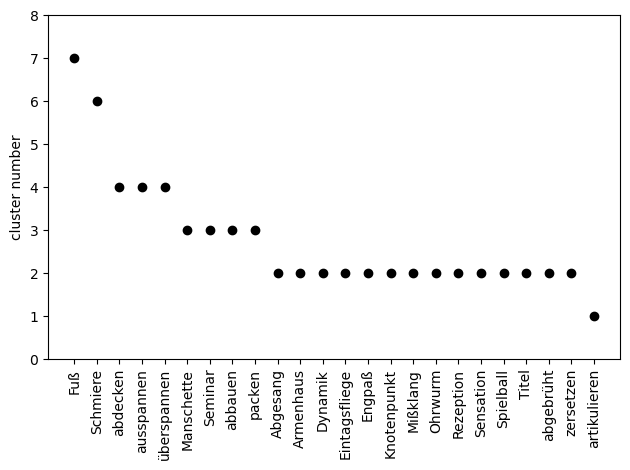

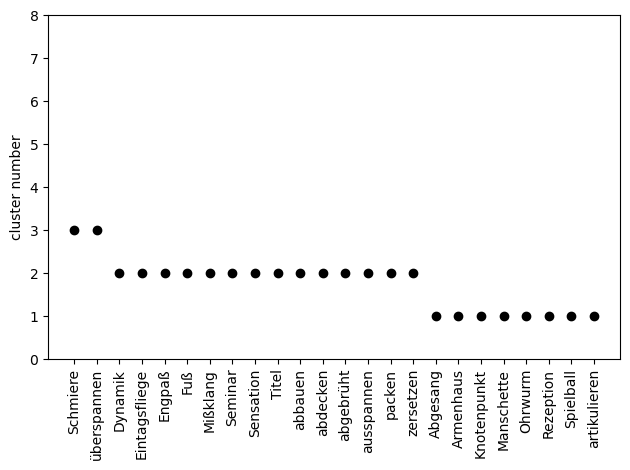

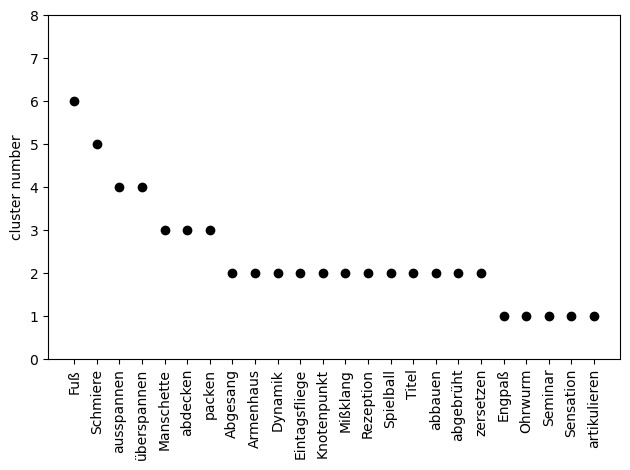

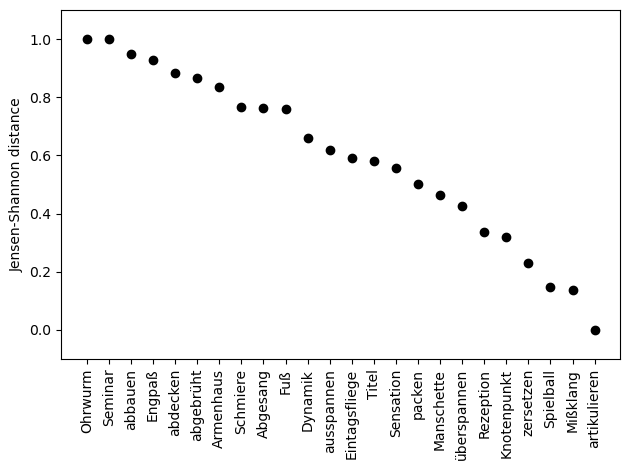

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
nice_colors = [x for x in mcolors.get_named_colors_mapping().values() if isinstance(x, str)] # Nice colors
colors_global = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'] # color-blind colors
colors_global = colors_global + nice_colors
from modules import *
import csv

lower_range_min=1
lower_range_max=3
upper_range_min=3
upper_range_max=5
lower_prob=0.01
upper_prob=0.1
old='1'
new='2'

plots_output = output_path + '/plots/distributions/maj_{0}'.format(threshold)
Path(plots_output).mkdir(parents=True, exist_ok=True)
cluster_number, cluster_number1, cluster_number2 = {}, {}, {}
change_graded = {}
stats = []
for word, graph in target2graph.items():
    general_stats = {'lemma':word}
    time_stats = get_time_stats(graph, threshold=0.5, lower_range=(int(lower_range_min), int(lower_range_max)), upper_range=(int(upper_range_min), int(upper_range_max)), lower_prob=float(lower_prob), upper_prob=float(upper_prob), old=old, new=new)
    time_stats.pop('nodes', None), time_stats.pop('nodes1', None), time_stats.pop('nodes2', None) # nodes only relevant for graphs 
    use_stats = {'uses': '{0}'.format(len([n for n in graph.nodes() if node2cluster[n]!=-1]))}
    use_stats = use_stats | {'uses1': '{0}'.format(len([n for n  in graph.nodes() if node2cluster[n]!=-1 and node2grouping[n]==1]))}
    use_stats = use_stats | {'uses2': '{0}'.format(len([n for n in graph.nodes() if node2cluster[n]!=-1 and node2grouping[n]==2]))}

    period_stats = {'grouping': '{0}_{1}'.format(old, new)}
    stats.append(general_stats | period_stats | use_stats | time_stats)
    
    # Get cluster numbers and change values for later plotting
    cluster_number[word], cluster_number1[word], cluster_number2[word] = time_stats['cluster_number'], time_stats['cluster_number1'], time_stats['cluster_number2']
    change_graded[word] = time_stats['change_graded']
    
    # Plot cluster frequency distributions
    distribution, distribution1, distribution2 = time_stats['cluster_freq_dist'], time_stats['cluster_freq_dist1'], time_stats['cluster_freq_dist2']
    fig, (ax1, axe, ax2, ax3) = plt.subplots(1, 4)
    #fig.suptitle(word)
    ax1.bar([str(i+1) for i, d in enumerate(distribution)], distribution, width=0.2, color=colors_global[:len(distribution)])
    ax2.bar([str(i+1) for i, d in enumerate(distribution1)], distribution1, width=0.2, color=colors_global[:len(distribution)])
    ax3.bar([str(i+1) for i, d in enumerate(distribution2)], distribution2, width=0.2, color=colors_global[:len(distribution)])
    ax1.set_xlabel('full', fontsize='medium')
    ax2.set_xlabel('old', fontsize='medium')
    ax3.set_xlabel('new', fontsize='medium')
    ax1.set_ylabel('number of uses', fontsize='medium')
    ax1.set_ylim(0, 50)    
    ax2.set_ylim(0, 50)    
    ax3.set_ylim(0, 50)    
    axe.axis('off') # empty subplot for spacing
    #ticks = [0, 0.1]
    #ax1.set_xticks(ticks)
    fig.tight_layout()    
    fig.savefig(plots_output+'/{0}.png'.format(word), dpi=100) # export figure
    plt.close()
    #break

# Plot cluster numbers
plots_output = output_path + '/plots/cluster_numbers/maj_{0}'.format(threshold)
Path(plots_output).mkdir(parents=True, exist_ok=True)
for word2cluster_number, name in [(cluster_number,'cluster_number'), (cluster_number1,'cluster_number1'), (cluster_number2,'cluster_number2')]:
    words_sorted = sorted(word2cluster_number, key=lambda x: word2cluster_number[x], reverse=True)
    cluster_numbers_sorted = [word2cluster_number[word] for word in words_sorted]
    plt.scatter(np.arange(0,len(words_sorted)*3,3), cluster_numbers_sorted, linestyle='None', color='k', marker='o')        
    plt.ylabel("cluster number", fontsize='medium')
    plt.ylim(0, 8)
    #plt.title(name, fontsize='medium')
    #words_sorted_short = [word.replace('abgebrüht', 'abgebr.').replace('Knotenpunkt', 'Knotenp.').replace('Eintagsfliege', 'Eintagsfl.').replace('Knotenpunkt', 'Knotenp.') for word in words_sorted]
    plt.xticks(np.arange(0,len(words_sorted)*3,3), words_sorted, fontsize='medium', rotation=90)
    plt.tight_layout()
    plt.savefig(plots_output+'/{0}.png'.format(name), dpi=100) # export figure 
    plt.show()
    plt.close()
 
# Plot graded change
plots_output = output_path + '/plots/change_graded/maj_{0}'.format(threshold)
Path(plots_output).mkdir(parents=True, exist_ok=True)
words_sorted = sorted(change_graded, key=lambda x: change_graded[x], reverse=True)
change_graded_sorted = [change_graded[word] for word in words_sorted]
plt.scatter(np.arange(0,len(words_sorted)*3,3), change_graded_sorted, linestyle='None', color='k', marker='o')        
plt.ylabel("Jensen-Shannon distance", fontsize='medium')
plt.ylim(-0.1, 1.1)
#plt.title('Graded Change', fontsize='medium')
#words_sorted_short = [word.replace('abgebrüht', 'abgebr.').replace('Knotenpunkt', 'Knotenp.').replace('Eintagsfliege', 'Eintagsfl.').replace('Knotenpunkt', 'Knotenp.') for word in words_sorted]
plt.xticks(np.arange(0,len(words_sorted)*3,3), words_sorted, fontsize='medium', rotation=90)
plt.tight_layout()
plt.savefig(plots_output+'/{0}.png'.format('change_graded'), dpi=100) # export figure 
plt.show()
plt.close()
    
# Export stats
stats_output = output_path + '/stats/maj_{0}'.format(threshold)
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/stats_groupings.csv'.format(threshold), 'w') as f:  
    w = csv.DictWriter(f, stats[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
    w.writeheader()
    w.writerows(stats)


In [9]:
# Get general statistics

stats = []
gb = df_dwug_de_senses.groupby('lemma')    
groups = gb.groups
for word in groups.keys():
    general_stats = {'lemma':word}
    #print(word)
    df_group = gb.get_group(word)
    general_stats['uses'] = df_group.shape[0]
    general_stats['excluded_uses'] = df_group['identifier_sense'].eq(-1).sum()
    stats.append(general_stats)

print(stats)   
# Export stats
stats_output = output_path + '/stats/maj_{0}'.format(threshold)
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/stats.csv'.format(threshold), 'w') as f:  
    w = csv.DictWriter(f, stats[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
    w.writeheader()
    w.writerows(stats)

[{'lemma': 'Abgesang', 'uses': 50, 'excluded_uses': 17}, {'lemma': 'Armenhaus', 'uses': 50, 'excluded_uses': 3}, {'lemma': 'Dynamik', 'uses': 50, 'excluded_uses': 19}, {'lemma': 'Eintagsfliege', 'uses': 50, 'excluded_uses': 14}, {'lemma': 'Engpaß', 'uses': 50, 'excluded_uses': 5}, {'lemma': 'Fuß', 'uses': 50, 'excluded_uses': 10}, {'lemma': 'Knotenpunkt', 'uses': 50, 'excluded_uses': 27}, {'lemma': 'Manschette', 'uses': 50, 'excluded_uses': 8}, {'lemma': 'Mißklang', 'uses': 50, 'excluded_uses': 14}, {'lemma': 'Ohrwurm', 'uses': 50, 'excluded_uses': 15}, {'lemma': 'Rezeption', 'uses': 50, 'excluded_uses': 4}, {'lemma': 'Schmiere', 'uses': 50, 'excluded_uses': 25}, {'lemma': 'Seminar', 'uses': 50, 'excluded_uses': 20}, {'lemma': 'Sensation', 'uses': 50, 'excluded_uses': 17}, {'lemma': 'Spielball', 'uses': 50, 'excluded_uses': 4}, {'lemma': 'Titel', 'uses': 50, 'excluded_uses': 24}, {'lemma': 'abbauen', 'uses': 50, 'excluded_uses': 10}, {'lemma': 'abdecken', 'uses': 50, 'excluded_uses': 3

In [10]:
# Extract clusters
gb = df_dwug_de_senses.groupby('lemma')    
groups = gb.groups
for word in groups.keys():
    df_group = gb.get_group(word)
    n2c = dict(zip(df_group['identifier'].to_list(),df_group['identifier_sense'].to_list()))
    output_data = [{'identifier':n, 'label':c} for n, c in n2c.items()]  
    
    # Export data
    stats_output = output_path + '/labels/{0}/maj_{1}'.format(word, threshold)
    Path(stats_output).mkdir(parents=True, exist_ok=True)
    with open(stats_output+'/labels_senses.csv'.format(word), 'w') as f:  
        w = csv.DictWriter(f, ['identifier', 'label'], delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
        w.writeheader()
        w.writerows(output_data)

Abgesang
Graph with 50 nodes and 1225 edges
Armenhaus
Graph with 50 nodes and 1225 edges
Dynamik
Graph with 50 nodes and 1225 edges
Eintagsfliege
Graph with 50 nodes and 1225 edges
Engpaß
Graph with 50 nodes and 1225 edges
Fuß
Graph with 50 nodes and 1225 edges
Knotenpunkt
Graph with 50 nodes and 1225 edges
Manschette
Graph with 50 nodes and 1225 edges
Mißklang
Graph with 50 nodes and 1225 edges
Ohrwurm
Graph with 50 nodes and 1225 edges
Rezeption
Graph with 50 nodes and 1225 edges
Schmiere
Graph with 50 nodes and 1225 edges
Seminar
Graph with 50 nodes and 1225 edges
Sensation
Graph with 50 nodes and 1225 edges
Spielball
Graph with 50 nodes and 1225 edges
Titel
Graph with 50 nodes and 1225 edges
abbauen
Graph with 50 nodes and 1225 edges
abdecken
Graph with 50 nodes and 1225 edges
abgebrüht
Graph with 50 nodes and 1225 edges
artikulieren
Graph with 50 nodes and 1225 edges
ausspannen
Graph with 50 nodes and 1225 edges
packen
Graph with 50 nodes and 1225 edges
zersetzen
Graph with 50 nod

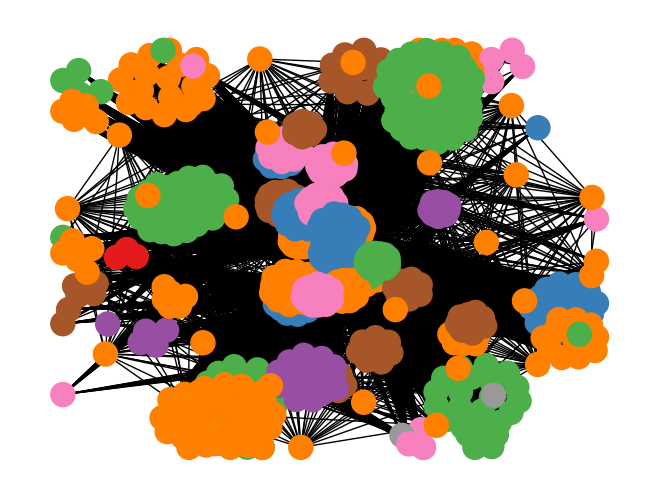

In [11]:
%matplotlib inline
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
nice_colors = [x for x in mcolors.get_named_colors_mapping().values() if isinstance(x, str)] # Nice colors
colors_global = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'] # color-blind colors
colors_global = colors_global + nice_colors
         
for word, graph in target2graph.items():
    graph = graph.copy()
    print(word)
    print(graph)
    enan=[(u,v) for (u,v,d) in graph.edges(data=True) if np.isnan(d['weight'])]
    graph.remove_edges_from(enan) # Remove nan edges for finding positions        
    # we remove isolated nodes
    graph.remove_nodes_from(list(nx.isolates(graph)))

    # Draw graph
    nx.draw(graph, with_labels=False, font_weight='bold', node_color=np.array(colors_global)[[int(node2cluster[node].replace('sense', '')) for node in graph.nodes()]])

    # Export inferred edge weights
    labels_inferred = [{'identifier1':u,'identifier2':v, 'label':d['weight'], 'lemma':word} for (u,v,d) in graph.edges(data=True)]
    labels_output = output_path + '/labels/{0}/maj_{1}'.format(word, threshold)
    Path(labels_output).mkdir(parents=True, exist_ok=True)
    with open(labels_output+'/labels_proximity.csv'.format(threshold), 'w') as f:  
        w = csv.DictWriter(f, labels_inferred[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
        w.writeheader()
        w.writerows(labels_inferred)

In [12]:
from sklearn.metrics import cohen_kappa_score, hamming_loss, accuracy_score
import krippendorff_ as krippendorff
import csv

stats = []
annotators = ['annotatorA', 'annotatorB', 'annotatorC']
df = df_dwug_de_senses[annotators + ['lemma']].replace('None', np.nan).replace('andere', np.nan)
df_ = pd.DataFrame()  
df_['lemma'] = df['lemma']
df_[annotators[0]] = df['lemma'] + df[annotators[0]] # prefix senses for uniqueness
df_[annotators[1]] = df['lemma'] + df[annotators[1]]
df_[annotators[2]] = df['lemma'] + df[annotators[2]]
display(df_)
stacked = df_[[annotators[0], annotators[1], annotators[2]]].stack()
df_[[annotators[0], annotators[1], annotators[2]]] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()
display(df_)
df = df_
indices_1 = df_dwug_de_senses[df_dwug_de_senses["grouping"]==1].index
indices_2 = df_dwug_de_senses[df_dwug_de_senses["grouping"]==2].index
df_1 = df.loc[indices_1]
df_2 = df.loc[indices_2]
assert len(df_1) + len(df_2) == len(df)

stats_agree = {}

# Krippendorff     
# Full data   
data = np.transpose(df.loc[:, annotators[0]:annotators[-1]].values)
kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print('full', kri)
stats_agree['kri_full'] = kri
    
# per time period
data = np.transpose(df_1.loc[:, annotators[0]:annotators[-1]].values)
kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print('full 1', kri)
stats_agree['kri_full_1'] = kri
data = np.transpose(df_2.loc[:, annotators[0]:annotators[-1]].values)
kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
print('full 2', kri)
stats_agree['kri_full_2'] = kri

# Pairwise
for a, b in combinations(annotators, 2):
    data = [df[a].values, df[b].values]
    kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    print('full', a, b, kri)
    stats_agree['kri_{0},{1}'.format(a, b)] = kri

# Cohen's kappa and Percentage Agreement
for metric, name in [(cohen_kappa_score, 'cohen_kappa'), (lambda x,y: 1-hamming_loss(x, y), 'ita')]:
    scores = []
    for a, b in combinations(annotators, 2):
        data = df[~df[a].isnull() & ~df[b].isnull()]
        data_a = data[a]
        data_b = data[b]
        if name == 'kri':
            score = metric([data_a, data_b])
        else:            
            score = metric(data_a, data_b)
        print('full', a, b, score)
        scores.append(score)
        stats_agree['{0}_{1},{2}'.format(name, a, b)] = score

    mean = np.mean(scores)    
    print('mean', mean)
    stats_agree['{0}_mean'.format(name)] = mean    

# first some general statistics
stats_agree['judgments_None'] = df_dwug_de_senses[[annotators[0], annotators[1], annotators[2]]].stack().eq('None').sum()
stats_agree['judgments_others'] = df_dwug_de_senses[[annotators[0], annotators[1], annotators[2]]].stack().eq('andere').sum()
stats_agree['judgments_total'] = (df_dwug_de_senses[[annotators[0], annotators[1], annotators[2]]].stack() != 'None').sum()    
stats_agree['avg_judgment_no'] = df_dwug_de_senses[[annotators[0], annotators[1], annotators[2]]].apply(lambda x: x!='None', axis = 1).sum(axis=1).mean()    
    
stats.append({'data':'full'} | stats_agree)


# By lemma
scores = []
stats_agree = {}
gb = df.groupby('lemma')
groups = gb.groups
gb1 = df_1.groupby('lemma')
groups1 = gb1.groups
gb2 = df_2.groupby('lemma')
groups2 = gb2.groups
# also group non-processed data frame
gb_full = df_dwug_de_senses.groupby('lemma')
groups_full = gb_full.groups
for word in groups.keys():
    
    df_group = gb.get_group(word)

    data = np.transpose(df_group.loc[:, annotators[0]:annotators[-1]].values)
    kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    #print(data)
    print(word, kri)
    stats_agree['kri_full'] = kri
     
    df_group1 = gb1.get_group(word)
    data = np.transpose(df_group1.loc[:, annotators[0]:annotators[-1]].values)
    #print(data)
    try:
        kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    except AssertionError:
        kri = np.nan
    stats_agree['kri_full_1'] = kri    
   
    df_group2 = gb2.get_group(word)
    data = np.transpose(df_group2.loc[:, annotators[0]:annotators[-1]].values)
    try:
        kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    except AssertionError:
        kri = np.nan
    stats_agree['kri_full_2'] = kri
    
    for a, b in combinations(annotators, 2):
        data = [df_group[a].values, df_group[b].values]
        kri = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
        print(word, a, b, kri)
        stats_agree['kri_{0},{1}'.format(a, b)] = kri
    
    for metric, name in [(cohen_kappa_score, 'cohen_kappa'), (lambda x,y: 1-hamming_loss(x, y), 'ita')]:
        scores = []
        for a, b in combinations(annotators, 2):
            data = df_group[~df_group[a].isnull() & ~df_group[b].isnull()]
            score = metric(data[a], data[b])
            print(word, a, b, score)
            scores.append(score)
            stats_agree['{0}_{1},{2}'.format(name, a, b)] = score

        mean = np.nanmean(scores)    
        print('mean', mean)
        stats_agree['{0}_mean'.format(name)] = mean
    
    # some general statistics
    df_group_full = gb_full.get_group(word)
    stats_agree['judgments_None'] = df_group_full[[annotators[0], annotators[1], annotators[2]]].stack().eq('None').sum()
    stats_agree['judgments_others'] = df_group_full[[annotators[0], annotators[1], annotators[2]]].stack().eq('andere').sum()
    stats_agree['judgments_total'] = (df_group_full[[annotators[0], annotators[1], annotators[2]]].stack() != 'None').sum()    
    stats_agree['avg_judgment_no'] = df_group_full[[annotators[0], annotators[1], annotators[2]]].apply(lambda x: x!='None', axis = 1).sum(axis=1).mean()    
    stats.append({'data':word} | stats_agree)
   
    
# Export stats
stats_output = output_path + '/stats'
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/stats_agreement.csv', 'w') as f:  
    w = csv.DictWriter(f, stats[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
    w.writeheader()
    w.writerows(stats)

,lemma,annotatorA,annotatorB,annotatorC
0,Dynamik,Dynamiksense2,Dynamiksense2,Dynamiksense2
1,Dynamik,Dynamiksense1,Dynamiksense2,Dynamiksense2
2,Dynamik,Dynamiksense2,Dynamiksense2,Dynamiksense2
3,Dynamik,Dynamiksense2,Dynamiksense2,Dynamiksense2
4,Dynamik,Dynamiksense2,Dynamiksense2,Dynamiksense2
...,...,...,...,...
1195,Titel,Titelsense5,Titelsense5,Titelsense5
1196,Titel,NaN,Titelsense3,NaN
1197,Titel,Titelsense6,Titelsense3,Titelsense3
1198,Titel,Titelsense5,Titelsense5,Titelsense5


,lemma,annotatorA,annotatorB,annotatorC
0,Dynamik,0.0,0.0,0.0
1,Dynamik,1.0,0.0,0.0
2,Dynamik,0.0,0.0,0.0
3,Dynamik,0.0,0.0,0.0
4,Dynamik,0.0,0.0,0.0
...,...,...,...,...
1195,Titel,72.0,72.0,72.0
1196,Titel,NaN,76.0,NaN
1197,Titel,75.0,76.0,76.0
1198,Titel,72.0,72.0,72.0


full 0.8674022038182758
full 1 0.8290518628506958
full 2 0.9050179928952315
full annotatorA annotatorB 0.8447226713092721
full annotatorA annotatorC 0.8874716338167626
full annotatorB annotatorC 0.8865034881789365
full annotatorA annotatorB 0.8447351696185531
full annotatorA annotatorC 0.8874646565531322
full annotatorB annotatorC 0.8864799312186071
mean 0.8728932524634309
full annotatorA annotatorB 0.847985347985348
full annotatorA annotatorC 0.889990089197225
full annotatorB annotatorC 0.8889934148635936
mean 0.8756562840153889
Abgesang 0.7749546279491832
Abgesang annotatorA annotatorB 0.7033333333333334
Abgesang annotatorA annotatorC 1.0
Abgesang annotatorB annotatorC 0.8402777777777778
Abgesang annotatorA annotatorB 0.7026431718061674
Abgesang annotatorA annotatorC 1.0
Abgesang annotatorB annotatorC 0.837962962962963
mean 0.8468687115897101
Abgesang annotatorA annotatorB 0.8666666666666667
Abgesang annotatorA annotatorC 1.0
Abgesang annotatorB annotatorC 0.9428571428571428
mean 0.9

zersetzen annotatorA annotatorB 0.023474178403755874
zersetzen annotatorA annotatorC 0.018181818181818188
zersetzen annotatorB annotatorC 0.9586776859504132
mean 0.3334445608453291
zersetzen annotatorA annotatorB 0.45833333333333337
zersetzen annotatorA annotatorC 0.4375
zersetzen annotatorB annotatorC 0.98
mean 0.6252777777777778
überspannen 0.546975546975547
überspannen annotatorA annotatorB 0.42739726027397273
überspannen annotatorA annotatorC 0.6040044493882091
überspannen annotatorB annotatorC 0.6050826946349335
überspannen annotatorA annotatorB 0.4382022471910112
überspannen annotatorA annotatorC 0.6
überspannen annotatorB annotatorC 0.6162790697674418
mean 0.5514937723194844
überspannen annotatorA annotatorB 0.62
überspannen annotatorA annotatorC 0.7333333333333334
überspannen annotatorB annotatorC 0.7555555555555555
mean 0.702962962962963


/mount/projekte50/projekte/cik/users/dominik/WUGs/scripts/misc/../krippendorff_.py:296: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (o * d).sum() / (e * d).sum()
/usr/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:658: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [13]:
# Export annotators
annotators_out = [{'annotator': annotator} for annotator in annotators]
stats_output = output_path 
Path(stats_output).mkdir(parents=True, exist_ok=True)
with open(stats_output+'/annotators.csv', 'w') as f:  
    w = csv.DictWriter(f, annotators_out[0].keys(), delimiter='\t', quoting = csv.QUOTE_NONE, quotechar='')
    w.writeheader()
    w.writerows(annotators_out)